In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# backshift operator B
# B^k X_t = X_(t-k)
# (1-B)^2 = 1-2B+B^2
# (1-B)^2 X_t = X_t - 2X_(t-1) + X_(t-2)


In [8]:
def getWeights(d, size):
    # thres>0 drops insignificant weights
    w = [1.0]
    for k in range(1, size):
        w_ = -w[-1] /k* (d - k + 1) 
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

In [9]:
def plotWeights(dRange, nPlots, size):
    w=pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        w_ = getWeights(d, size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w=w.join(w_, how='outer')
    ax=w.plot()
    ax.legend(loc='upper right')
    plt.show()
    return 

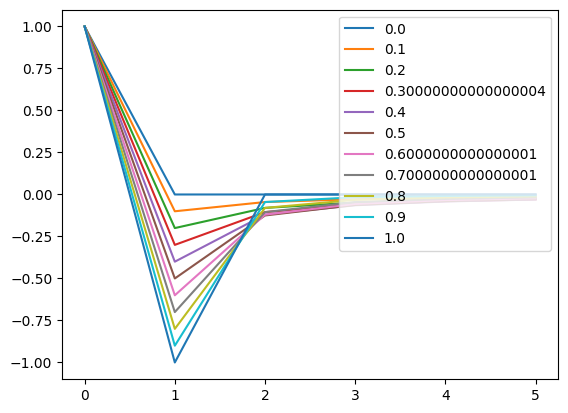

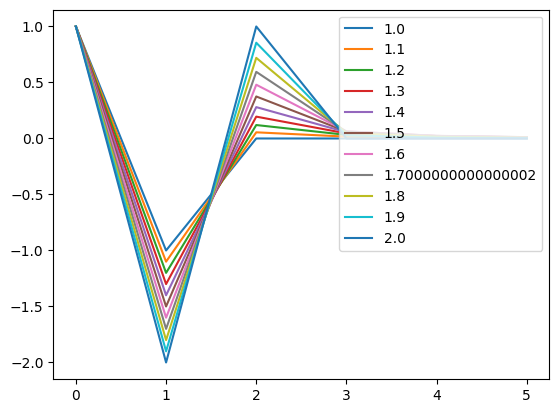

In [10]:
if __name__ == "__main__":
    plotWeights(dRange=[0, 1], nPlots=11, size=6)
    plotWeights(dRange=[1, 2], nPlots=11, size=6)

In [55]:
def fracDiff(series,d,thres=.01):
    '''
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped.
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    #1) Compute weights for the longest series
    w=getWeights(d,series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_=np.cumsum(abs(w))
    w_/=w_[-1]
    skip=w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
        for iloc in range(skip,seriesF.shape[0]):
            loc=seriesF.index[iloc]
            if not np.isfinite(series.loc[loc,name]):continue # exclude NAs
            df_[loc]=np.dot(w[-(iloc+1):,:].T,seriesF.loc[:loc])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

In [56]:
np.random.seed(0)
series = pd.DataFrame({'price': np.cumsum(np.random.randn(10)) + 100})
print(series)

        price
0  101.764052
1  102.164210
2  103.142948
3  105.383841
4  107.251399
5  106.274121
6  107.224209
7  107.072852
8  106.969633
9  107.380232


In [61]:
df = fracDiff(series, d=0.2, thres=0.04)
df

C:\Users\praty\AppData\Local\Temp\ipykernel_3840\1803447509.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()


,price
7,61.993634
8,60.280696
9,59.326555


In [1]:
def getWeights_FFD(d, thres):
    # thres>0 drops insignificant weights
    w = [1.0]
    k = 1
    while True:
        w_ = -w[-1] /k* (d - k + 1) 
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

In [73]:
def fracDiff_FFD(series,d,thres=1e-5):
    '''
    Constant width window (new solution)
    Note 1: thres determines the cut-off weight for the window
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    #1) Compute weights for the longest series
    w=getWeights_FFD(d, thres)
    width=len(w)-1
    #2) Apply weights to values
    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):
            loc0,loc1=seriesF.index[iloc1-width],seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1,name]):continue # exclude NAs
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df


In [74]:
df_ = fracDiff_FFD(series, d=0.2, thres=0.04)

C:\Users\praty\AppData\Local\Temp\ipykernel_3840\2862411651.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()


In [75]:
df_

,price
3,71.697440
4,73.019313
5,71.442272
6,72.330849
7,71.978013
8,71.875968
9,72.273715
